In [1]:
import numpy as np
import pyregion
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

In [2]:
shapes = pyregion.open("904686.reg")

In [3]:
sizes = set()
for shape in shapes:
    sizes.add(repr(shape.params[2]))
print(sizes)

{'Ang(128.9")', 'Ang(29.8")', 'Ang(138")'}


In [4]:
#blue = primary mirror
#red = camera lens = main source of obscuration
#green = camera shadow

blue = []
red = []
green = []
for shape in shapes:
    p = shape.params
    if repr(p[2]) == 'Ang(29.8")':
        green.append((p[0].degree, p[1].degree))
    elif repr(p[2]) == 'Ang(128.9")':
        blue.append((p[0].degree, p[1].degree))
    elif repr(p[2]) == 'Ang(138")':
        red.append((p[0].degree, p[1].degree))
    else:
        print("PANIC!")

In [5]:
blue = np.array(blue)
cgreen = np.array(green)
cred = np.array(red)
green = np.zeros_like(cgreen)
red = np.zeros_like(cred)

In [6]:
#Associate correct "red", "green" with given "blue"
for i, b in enumerate(blue):
    d = np.sum((b - cgreen)**2, axis=1)
    green[i] = cgreen[np.argmin(d)]
    d = np.sum((b - cred)**2, axis=1)
    red[i] = cred[np.argmin(d)]

In [7]:
# The RA axis needs to be adjusted for the given declination (we'll just take the mean declination)
meandec = np.mean(blue[:,1]) * np.pi/180 #deg_to_rad
print(meandec)
print(1./np.cos(meandec))
blue[:,0] /= np.cos(meandec)
red[:,0] /= np.cos(meandec)
green[:,0] /= np.cos(meandec)

0.344849069822
1.06255643094


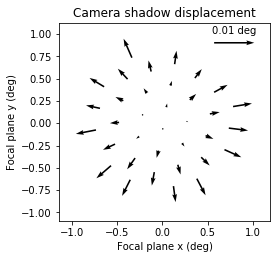

In [18]:
plt.figure(figsize=(4,3.7))
Q = plt.quiver(blue[:,0]-np.mean(blue[:,0]), blue[:,1]-np.mean(blue[:,1]), 
               (green-blue)[:,0], (green-blue)[:,1])
plt.quiverkey(Q, 0.83, 0.9, 1e-2, '0.01 deg', labelpos='N')
l, r, b, t = plt.axis()
dx, dy = r - l, t - b
plt.axis([l - 0.2*dx, r + 0.2*dx, b - 0.2*dy, t + 0.2*dy])
plt.title("Camera shadow displacement")
plt.xlabel("Focal plane x (deg)")
plt.ylabel("Focal plane y (deg)")
plt.tight_layout()
plt.savefig("/Users/josh/Desktop/camera_shadow_displacement.png", dpi=300)
plt.show()

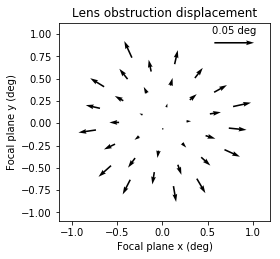

In [19]:
plt.figure(figsize=(4,3.7))
Q = plt.quiver(blue[:,0]-np.mean(blue[:,0]), blue[:,1]-np.mean(blue[:,1]), 
               (red-blue)[:,0], (red-blue)[:,1])
plt.quiverkey(Q, 0.83, 0.9, 0.05, '0.05 deg', labelpos='N')
l, r, b, t = plt.axis()
dx, dy = r - l, t - b
plt.axis([l - 0.2*dx, r + 0.2*dx, b - 0.2*dy, t + 0.2*dy])
plt.title("Lens obstruction displacement")
plt.xlabel("Focal plane x (deg)")
plt.ylabel("Focal plane y (deg)")
plt.tight_layout()
plt.savefig("/Users/josh/Desktop/l1_displacement.png", dpi=300)
plt.show()

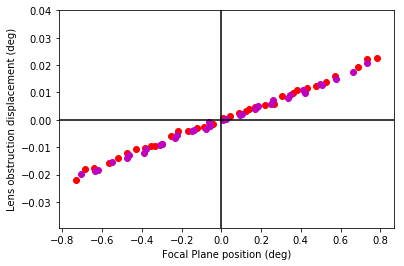

In [10]:
plt.scatter(blue[:,0]-np.mean(blue[:,0]), (red-blue)[:,0], c='r')
plt.scatter(blue[:,1]-np.mean(blue[:,1]), (red-blue)[:,1], c='m')
plt.axhline(c='k')
plt.axvline(c='k')
plt.xlabel("Focal Plane position (deg)")
plt.ylabel("Lens obstruction displacement (deg)")
plt.show()

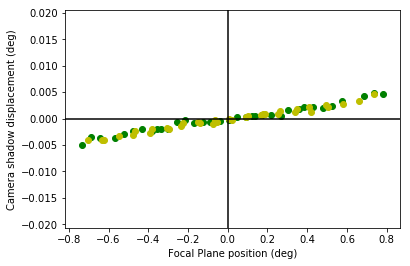

In [11]:
plt.scatter(blue[:,0]-np.mean(blue[:,0]), (green-blue)[:,0], c='g')
plt.scatter(blue[:,1]-np.mean(blue[:,1]), (green-blue)[:,1], c='y')
plt.axhline(c='k')
plt.axvline(c='k')
plt.xlabel("Focal Plane position (deg)")
plt.ylabel("Camera shadow displacement (deg)")
plt.show()

Estimated coefficients
[ 0.00557744]


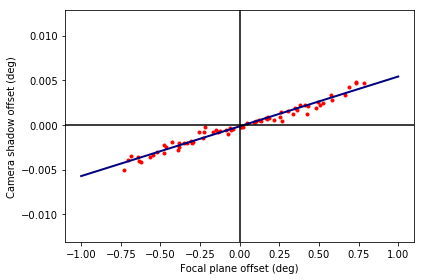

In [20]:
X = np.hstack([blue[:, 0] - np.mean(blue[:, 0]), blue[:, 1] - np.mean(blue[:, 1])])
X = X[:, np.newaxis]
y1 = np.hstack([(green-blue)[:, 0], (green-blue)[:, 1]])

model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X, y1)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.linspace(-1, 1)
line_y = model_ransac.predict(line_X[:, np.newaxis])

print("Estimated coefficients")
print(model_ransac.estimator_.coef_)

plt.figure(figsize=(6, 4))
plt.scatter(X[inlier_mask], y1[inlier_mask], color='red', marker='.', label='Inliers')
# plt.scatter(X[outlier_mask], y1[outlier_mask], color='gold', marker='.', label='Outliers')
plt.plot(line_X, line_y, color='navy', linestyle='-', linewidth=2, label='Regression')
# plt.legend(loc='upper left')
plt.axhline(c='k')
plt.axvline(c='k')
plt.xlabel("Focal plane offset (deg)")
plt.ylabel("Camera shadow offset (deg)")
plt.tight_layout()
plt.savefig("/Users/josh/Desktop/camera_shadow_fit.png", dpi=300)
plt.show()

Estimated coefficients
[ 0.02758181]


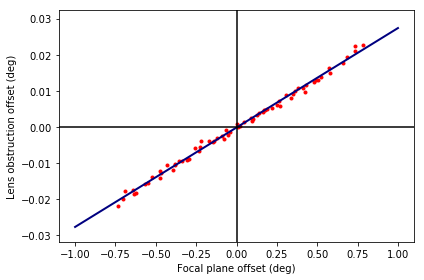

In [21]:
X = np.hstack([blue[:, 0] - np.mean(blue[:, 0]), blue[:, 1] - np.mean(blue[:, 1])])
X = X[:, np.newaxis]
y2 = np.hstack([(red-blue)[:, 0], (red-blue)[:, 1]])

model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X, y2)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.linspace(-1, 1)
line_y = model_ransac.predict(line_X[:, np.newaxis])

print("Estimated coefficients")
print(model_ransac.estimator_.coef_)

plt.figure(figsize=(6, 4))
plt.scatter(X[inlier_mask], y2[inlier_mask], color='red', marker='.', label='Inliers')
# plt.scatter(X[outlier_mask], y2[outlier_mask], color='gold', marker='.', label='Outliers')
plt.plot(line_X, line_y, color='navy', linestyle='-', linewidth=2, label='Regression')
# plt.legend(loc='upper left')
plt.axhline(c='k')
plt.axvline(c='k')
plt.xlabel("Focal plane offset (deg)")
plt.ylabel("Lens obstruction offset (deg)")
plt.tight_layout()
plt.savefig("/Users/josh/Desktop/l1_fit.png", dpi=300)
plt.show()